In [13]:
# Import necessary libraries
import os
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import solve
import numpy.linalg as linalg

import geomdl
from geomdl import BSpline
from geomdl import knotvector
from geomdl import NURBS
from geomdl import fitting
from geomdl.visualization import VisMPL as vis

from scipy.ndimage import convolve, generate_binary_structure
from scipy import optimize
from scipy.interpolate import splprep, splev

from meshpy.tet import MeshInfo, build
import meshpy.triangle as triangle

import math
import FEM
import Interpolation

cwd = os.getcwd()

# Load control points from CSV file
ctrlpts = []
with open(cwd + '/ctrl_points_file.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        if row != [] and row != ['x_pos', 'y_pos']:
            ctrlpts.append([float(row[0]), float(row[1])])

# Function to create a NURBS curve from control points
def create_nurbs_curve(control_points):
    # Initialize a NURBS curve object
    curve = NURBS.Curve()

    # Set the degrees of the curve
    curve.degree = 2

    # Set the control points
    curve.ctrlpts = control_points

    # Set the knot vector
    curve.knotvector = knotvector.generate(curve.degree, curve.ctrlpts_size)

    return curve

# Function to evaluate a curve at a given parameter t
def Z(t, curve):
    point = curve.evaluate_single(t)
    return point[:2]  # Discard the last coordinate (if 3D)

curve = create_nurbs_curve(ctrlpts)

In [14]:
def round_trip_connect(start, end):
    return [(i, i + 1) for i in range(start, end)] + [(end, start)]

def needs_refinement(vertices, area):
        bary = np.sum(np.array(vertices), axis=0) / 3
        max_area = 1 + (linalg.norm(bary, np.inf) - 1) * 0.2
        return bool(area > max_area)

time spend building the triangular mesh
0.09217596054077148


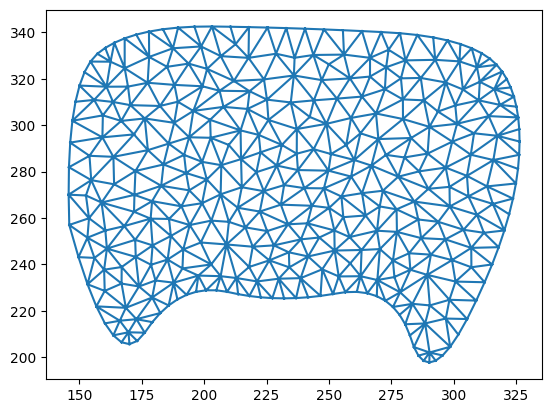

In [26]:
N = 100

s_values = np.linspace(0, 1, N+1)
s_values = s_values[:-1]
crvpts = [Z(t, curve) for t in s_values]
crv_x = [Z(t, curve)[0] for t in s_values]
crv_y = [Z(t, curve)[1] for t in s_values]

t2 = time.time()
info = triangle.MeshInfo()
facets = round_trip_connect(0, len(crvpts) - 1)
circ_start = len(crvpts)
facets.extend(round_trip_connect(circ_start, len(crvpts) - 1))
info.set_points(crvpts)
info.set_facets(facets)
mesh = triangle.build(info, refinement_func=needs_refinement)

mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
t3 = time.time()
print('time spend building the triangular mesh')
print(t3-t2)
plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.show()



Time spend with constructing stiffness matrix
0.5945391654968262
Time spend solving the linear equations
0.0009999275207519531


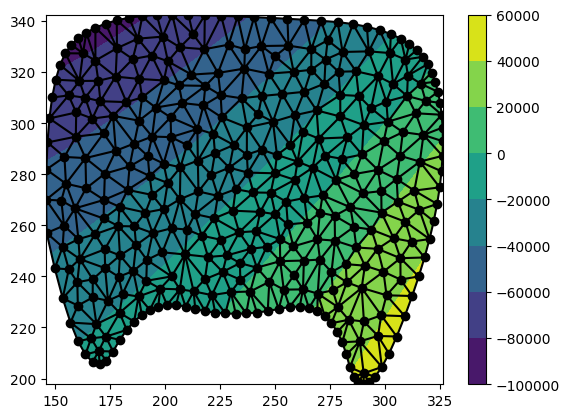

time spend in total with FEM
2.1447017192840576


In [29]:
# let's assume f(x,y) = x^2 - y^2 on the boundary
t0 = time.time()
psi = [x*x - y*y for x, y in zip(crv_x,crv_y)] 

solution = FEM.laplace_solver(mesh_points,mesh_tris, crvpts, psi)
x = []
y = []
for i in mesh_points:
    x.append(i[0])
    y.append(i[1])
 
Interpolation.interpolation(x,y,mesh_tris,solution)
t1 = time.time()
print('time spend in total with FEM')
print(t1-t0)